In [1]:
# Some imports
import numpy as np
import matplotlib.pyplot as plt

import sympy as sp

from scipy.integrate import quad
from scipy.interpolate import interp1d
from scipy.special import spherical_jn

from iminuit import Minuit
from GaussianCovariance import *
from scipy.stats import multivariate_normal as mvn
from tqdm.notebook import tqdm

# Cross covariance AP parameters - 2PCF

This notebook will apply the methodology in 4.2 of https://arxiv.org/abs/2002.04035

This is an attempt to write a simple analytical formula for the cross power spectrum - AP parameters:

$$ Cov[P(\mathbf{k}), \mathbf{\alpha}] = <\delta P(\mathbf{k}) \delta \mathbf{\alpha} >$$

This can be rewritten as:

$$ Cov[P(\mathbf{k}), \mathbf{\alpha}] = <\frac{\partial{P(\mathbf{k})}}{\partial{\alpha}} \delta\mathbf{\alpha}^T \delta \mathbf{\alpha} > = \frac{\partial{P(\mathbf{k})}}{\partial{\alpha}} Cov[\mathbf{\alpha}, \mathbf{\alpha}]$$

Notice that this applies to any combination of parameters.

The goal of this notebook is to provide a similar formula for $\xi(r)$. 
For simplicity, we will limit to the case of isotropic 2PCF and isotropic AP parameter $\alpha$.

We recall that:

$$ \xi(r) = \frac{1}{2 \pi^2} \int \mathrm{d}k k^2 P(k) j_0(k r).$$

Than, similar formula applies:

$$ Cov[\xi(r), \alpha] = <\delta \xi(r) \delta \mathbf{\alpha} > = \frac{\partial{\xi(r)}}{\partial{\alpha}} Cov[\alpha, \alpha]$$

The procedure will go as follow: first, we define the analytical formula for $Cov[\xi(r), [\alpha]]$. We then generate mock measurements and fit them individually. We then construct the new observable $\xi_i, \alpha_i$, and estimate the numerical covariance out of it.
We then compare the measured and analytical cross covariance.

But first...

## A trivial case, $Cov[\xi(r), b]$

Befor entering the detailed computation for AP, we want to test the pipeline on a much simpler case, the 2PCF-bias cross covariance:

We assume:

$$ \xi_g(r) = b^2 \xi_m(r).$$

It is then trivial to write down analytically the cross covariance term:

$$Cov[\xi(r), b] = 2 b \xi_m(r) Cov[b, b]$$


In [2]:
# Generate a 2PCF

# Read the power spectrum

kk, pk = np.genfromtxt("pk.dat", unpack=True, usecols=(0, 1))
interp_log_pk = interp1d(np.log(kk), np.log(pk), fill_value="extrapolate", kind="linear")

interp_pk = lambda kk : np.exp(interp_log_pk(np.log(kk)))

In [3]:
# Define the P(k)->2PCF function

def get_xi_matter(rad, interp_pk):
    return quad(lambda k : interp_pk(k) * k**2 * np.sin(k*rad) / (k * rad) * np.exp(-k**2) , 0, np.inf)[0]/ (2 * np.pi**2)

In [4]:
# Assume some parameters

#Survey parameters
b = 2
f = 0
side = 1500
n_bar = 1.e-3

In [5]:
# 2CPF parameters
rad_edges = np.linspace(50, 150, 21)
rad_bins = 0.5 * (rad_edges[1:] + rad_edges[:-1])

# Target 2PCF
xi_matter = np.array([get_xi_matter(rr, interp_pk) for rr in rad_bins])
xi_gal = b**2 * xi_matter

/tmp/ipykernel_33978/2639329207.py:4: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(lambda k : interp_pk(k) * k**2 * np.sin(k*rad) / (k * rad) * np.exp(-k**2) , 0, np.inf)[0]/ (2 * np.pi**2)


Text(0, 0.5, '$r^2 \\xi(r)$')

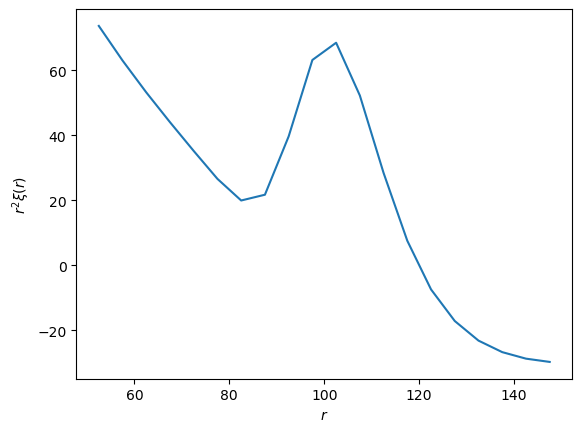

In [6]:
plt.plot(rad_bins, rad_bins**2 * xi_gal)
plt.xlabel(r"$r$")
plt.ylabel(r"$r^2 \xi(r)$")

In [7]:
# In order to generate mocks, we need to generage a covariance.
# We assume Grieb et al., as implemented in the package gaussiancovariance

p_k_mu = lambda k, mu : (b + f * mu**2) **2 * interp_pk(k)

xi_covariance = TwoPointGaussianCovariance(rad_edges, [0,], deg=51, deg_k=15)
cov = xi_covariance(p_k_mu, side**3, n_bar)

icov = np.linalg.inv(cov)

Computing Bessels functions...
Done!
Computing tabulated sigma squared...
Done!


In [8]:
# Now let's generate some measures

n_mocks = 100000

xi_mocks = mvn.rvs(mean=xi_gal, cov=cov, size=n_mocks)

In [9]:
# Let's now fit the mocks

def chi2(b, i):
    diff = xi_mocks[i]-b**2*xi_matter
    return np.dot(diff, np.dot(icov,diff))

bias_fit = np.zeros(n_mocks)
for i in tqdm(range(n_mocks)):
        
    mm = Minuit(lambda b: chi2(b, i), b=2.)
    mm.migrad()
    bias_fit[i] = mm.values[0]


  0%|          | 0/100000 [00:00<?, ?it/s]

In [10]:
# Let's now build the cross covariance
xi_b = np.array([xi_mocks[i].tolist()+[bias_fit[i],] for i in range(n_mocks)])

cross_cov = np.cov(xi_b.T)
var_b = cross_cov[-1, -1]

Text(0, 0.5, '$Cov[\\xi(r), b]$')

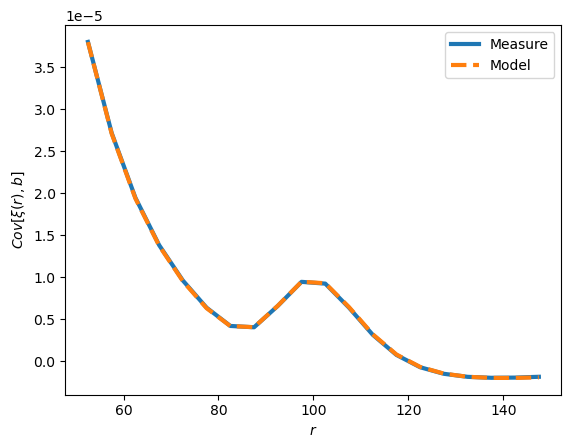

In [11]:
plt.plot(rad_bins, cross_cov[-1, :-1], lw = 3, label="Measure")
plt.plot(rad_bins, 2*b*xi_matter * var_b, ls = "--", lw=3, label="Model")
plt.legend(loc="best")
plt.xlabel(r"$r$")
plt.ylabel(r"$Cov[\xi(r), b]$")

Nice!!!

Let's move to isotropic AP

## Case of study: $Cov[\xi(r), \alpha]$

Let's do some simple math:

The 2PCF model reads:

$$ \xi_g(\alpha r) = b^2 \xi_m(\alpha r); $$

we now need to compute its derivative. By writing down explicitely $$\xi_g(\alpha r)$$ we recognize that this derivative is analytical, and only acts on $j_0(kr)$

$$ \frac{\partial{\xi_g(\alpha r)}}{\partial{\alpha}} = \frac{1}{2 \pi^2} \int \mathrm{d}k k^2 P(k) \frac{\partial{j_0(k r \alpha)}}{\partial{\alpha}}.$$


In [12]:
# Let's code...
k, r = sp.symbols('k r', real=True, positive=True)
alpha = sp.symbols('alpha', real=True, positive=True)

xi = sp.Function('xi')(r, alpha)


j0 = sp.sin(k*r*alpha)/(k*r*alpha)

j0_diff_a = sp.diff(j0, alpha)


In [13]:
sp.Eq(sp.jn(0, k*r*alpha), j0)

Eq(jn(0, alpha*k*r), sin(alpha*k*r)/(alpha*k*r))

In [14]:
sp.Eq(sp.Derivative(sp.jn(0, k*r*alpha), alpha), j0_diff_a)

Eq(Derivative(jn(0, alpha*k*r), alpha), cos(alpha*k*r)/alpha - sin(alpha*k*r)/(alpha**2*k*r))

Then we have:

In [15]:
sp.Eq(sp.Derivative(xi, alpha),  sp.Integral(k**2 * sp.Function("P")(k) *  j0_diff_a, (k, 0, sp.oo)))

Eq(Derivative(xi(r, alpha), alpha), Integral(k**2*(cos(alpha*k*r)/alpha - sin(alpha*k*r)/(alpha**2*k*r))*P(k), (k, 0, oo)))

This is related to $j_1(kr)$, but we ignore that at the moment, and use the result as it is

In [16]:
# Turn formula to executable
xi_prime_integrand_func = sp.lambdify((k, r), j0_diff_a.subs(alpha, 1))

def get_xi_alpha_der(r):
    return b**2 * quad(lambda k : interp_pk(k) * k**2 * xi_prime_integrand_func(k, r) * np.exp(-k**2), 0, np.inf)[0]/ (2 * np.pi**2)

xi_alpha_der = np.array([get_xi_alpha_der(rr) for rr in rad_bins])

/tmp/ipykernel_33978/4083941421.py:5: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return b**2 * quad(lambda k : interp_pk(k) * k**2 * xi_prime_integrand_func(k, r) * np.exp(-k**2), 0, np.inf)[0]/ (2 * np.pi**2)


In [17]:
# Let's now fit the mocks

# Create xi interpolator
r_interp = np.linspace(1, 200, 100)
xi_matter_interp = np.array([get_xi_matter(rr, interp_pk) for rr in r_interp])
interp_xi = interp1d(r_interp, xi_matter_interp, kind="linear", fill_value="extrapolate")


/tmp/ipykernel_33978/2639329207.py:4: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(lambda k : interp_pk(k) * k**2 * np.sin(k*rad) / (k * rad) * np.exp(-k**2) , 0, np.inf)[0]/ (2 * np.pi**2)


In [18]:
# Perform the fit
def chi2(alpha, i):
    diff = xi_mocks[i]-b**2*interp_xi(alpha*rad_bins)
    return np.dot(diff, np.dot(icov,diff))

alpha_fit = np.zeros(n_mocks)
for i in tqdm(range(n_mocks)):
        
    mm = Minuit(lambda alpha: chi2(alpha, i), alpha=1)
    mm.migrad()
    alpha_fit[i] = mm.values[0]

  0%|          | 0/100000 [00:00<?, ?it/s]

In [19]:
# Let's now build the cross covariance
xi_alpha = np.array([xi_mocks[i].tolist()+[alpha_fit[i],] for i in range(n_mocks)])

cross_cov = np.cov(xi_alpha.T)
var_alpha = cross_cov[-1, -1]

Text(0, 0.5, '$Cov[\\xi(r), \\alpha]$')

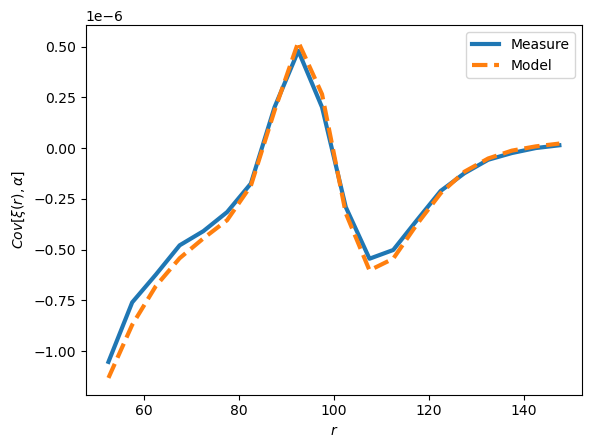

In [20]:
plt.plot(rad_bins, cross_cov[-1, :-1], lw = 3, label="Measure")
plt.plot(rad_bins, xi_alpha_der * var_alpha, ls = "--", lw=3, label="Model")
plt.legend(loc="best")
plt.xlabel(r"$r$")
plt.ylabel(r"$Cov[\xi(r), \alpha]$")

Again, NICE!!!

Of course, this is a very simplificative exercise.

We should complicate the picture in order to get proper dependency. Also, we should test this approach with respect to non gaussianity in the posterior of alphas.

But this is a promising beginning..